<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S5/EVA4_Session_5_MNIST_Step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5 _Step - 4_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **MNIST** |
  | _Max. number of epochs_| **15** |
  | _Max. number of parameters_| **10K** |
  | _Consistent_ _**99.4**_ _for last epochs_| |


# Implementation

## Initialization

### Mounting google drive to save results

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import and install all required libraries

In [47]:
!pip install torchsummary
!pip install torchviz
!pip install receptivefield>=0.5.0

import datetime
import glob

import numpy as np
import pandas as pd
import cv2

from __future__ import print_function        # Import for print statement
import torch                                 # Import pytorch library
import torch.nn as nn                        # Import neural net module from pytorch
import torch.nn.functional as F              # Import functional interface from pytorch
import torch.optim as optim                  # Import optimizer module from pytorch

from torchvision import datasets, transforms # Import datasets and augmentation functionality from vision module within pytorch
from torchsummary import summary             # Import summary with pytorch
from torchviz import make_dot

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

In [0]:
use_cuda = torch.cuda.is_available()                  # Check cuda avaliability

In [0]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

## Load MNIST Dataset

### Initialize _transforms_, _dataset_ & _dataloader_

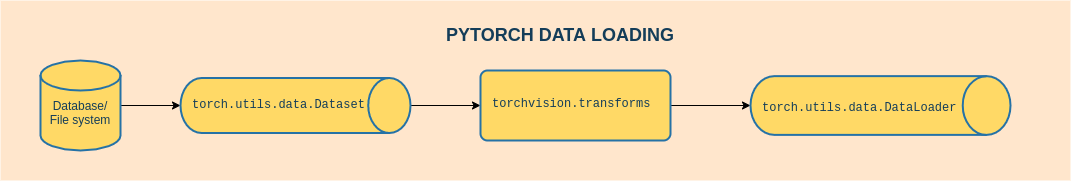

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       # transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       # transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
batch_size = 64

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## Preliminary exploratory analysis

#### Useful stats

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


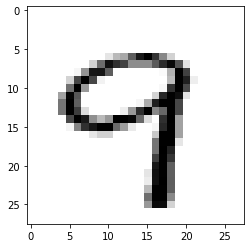

In [53]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

#### Batch visualization

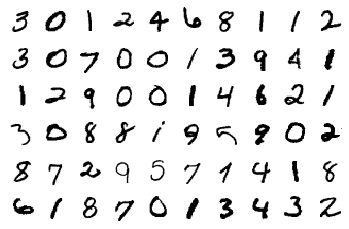

In [54]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Experiment
### Strategy
  - Raw bulky model without any optimizations
  - Nothing fancy just getting the workflow right!

In [0]:
experiment_name = 's5-step-4-batch-norm-dropout-gap'

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #########################################################################################
        # INPUT BLOCK
        #########################################################################################
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 26
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # CONVOLUTION BLOCK 1
        #########################################################################################
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 24
        #----------------------------------------------------------------------------------------
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 22
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # TRANSITION BLOCK 1
        #########################################################################################
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 11
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # CONVOLUTION BLOCK 2
        #########################################################################################
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 9
        #----------------------------------------------------------------------------------------
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 7
        #----------------------------------------------------------------------------------------
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 5
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # GAP BLOCK
        #########################################################################################
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )
        #########################################################################################
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 1
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # OUTPUT BLOCK
        #########################################################################################
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 1
        #----------------------------------------------------------------------------------------
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

###Summary

####Textual summary

In [57]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPU
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 16,

####Graphical summary

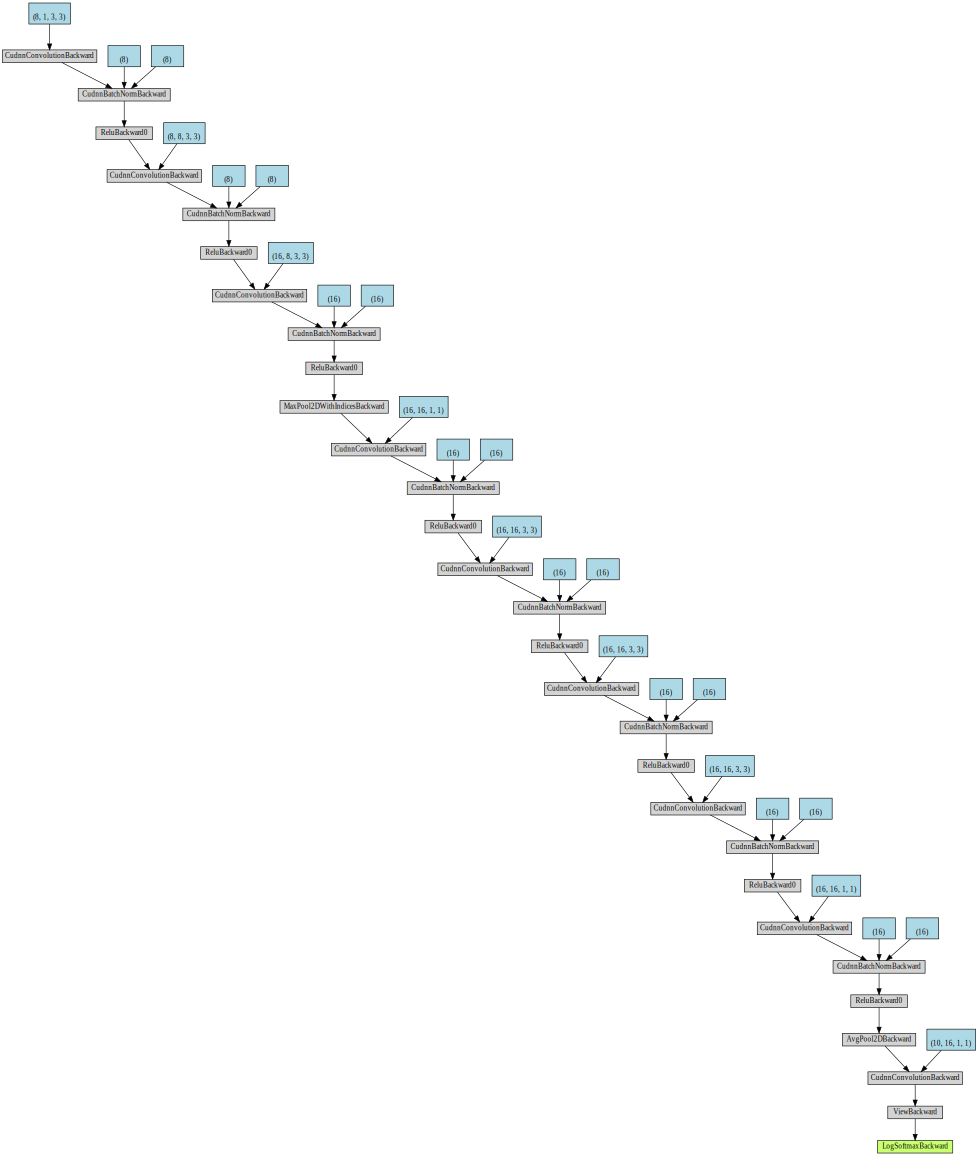

In [58]:
random_input = torch.randn(1, 1, 28, 28).cuda() if use_cuda else torch.randn(1, 1, 28, 28) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

### Training

#### Training routine

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)

    for batch_idx, (data, target) in enumerate(pbar):
        
        # Move data to cpu/gpu based on input
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Loss computation
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        
        # Predictions
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Backward pass
        batch_loss.backward()
        
        # Gradient descent
        optimizer.step()

        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.2f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

#### Testing routine

In [0]:
def test(model, device, test_loader, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):

            # Move data to cpu/gpu based on input
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Loss computation
            batch_loss = F.nll_loss(output, target, reduction='sum').item()
            test_loss += batch_loss

            # Predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Logging - updating progress bar and summary writer
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.2f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

### Execution

In [61]:
now = datetime.datetime.now()
prefix = now.strftime('%m-%d-%y %H:%M:%S')

train_dir_suffix = f'/content/drive/My Drive/log_mnist_s5/run_train_{experiment_name}'
test_dir_suffix = f'/content/drive/My Drive/log_mnist_s5/run_test_{experiment_name}'

train_dir = f'{train_dir_suffix}_{prefix}'
test_dir = f'{test_dir_suffix}_{prefix}'

train_writer = SummaryWriter(train_dir)
test_writer = SummaryWriter(test_dir)

model = Net().to(device)
lr = 0.01
epochs = 15
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(0, epochs):
    train(model, device, train_loader, optimizer, epoch, train_writer)
    test(model, device, test_loader, epoch, test_writer)

TRAIN : epoch=0 train_loss=0.00632 correct/total=53544/60000 accuracy=89.24: 100%|██████████| 938/938 [00:20<00:00, 45.89it/s]
TEST :  epoch=0 test_loss=0.07408 correct/total=9789/10000 accuracy=97.89: 100%|██████████| 157/157 [00:02<00:00, 57.19it/s]
TRAIN : epoch=1 train_loss=0.00120 correct/total=58695/60000 accuracy=97.83: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]
TEST :  epoch=1 test_loss=0.03754 correct/total=9891/10000 accuracy=98.91: 100%|██████████| 157/157 [00:02<00:00, 61.81it/s]
TRAIN : epoch=2 train_loss=0.00090 correct/total=59007/60000 accuracy=98.34: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s]
TEST :  epoch=2 test_loss=0.03172 correct/total=9909/10000 accuracy=99.09: 100%|██████████| 157/157 [00:02<00:00, 57.99it/s]
TRAIN : epoch=3 train_loss=0.00077 correct/total=59084/60000 accuracy=98.47: 100%|██████████| 938/938 [00:19<00:00, 49.18it/s]
TEST :  epoch=3 test_loss=0.02917 correct/total=9912/10000 accuracy=99.12: 100%|██████████| 157/157 [00:02<00:00, 63.

# Outputs

## Feature maps

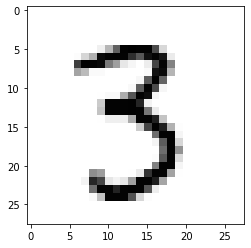

In [62]:
sample_index = 2
batch_data = next(iter(train_loader))[0]
x = next(iter(train_loader))[0][sample_index : sample_index + 1]
plt.set_cmap('Greys')
plt.imshow(x.view((28, 28)))
plt.show()

In [0]:
def get_activations(model):
  model.eval()
  activations = {}
  def get_activation(name):
      def hook(model, input, output):
          activations[name] = np.hstack(output.squeeze(0).cpu().detach().numpy()[0:10, :, :])
          # print(name, activations[name].shape)
      return hook

  model.convblock3.register_forward_hook(get_activation('Block 3'))
  model.convblock5.register_forward_hook(get_activation('Block 5'))
  model.convblock8.register_forward_hook(get_activation('Block 7'))
  model.convblock9.register_forward_hook(get_activation('Output'))

  y = model(Variable(x.cuda() if use_cuda else x))
  return activations

In [0]:
activations = get_activations(model)

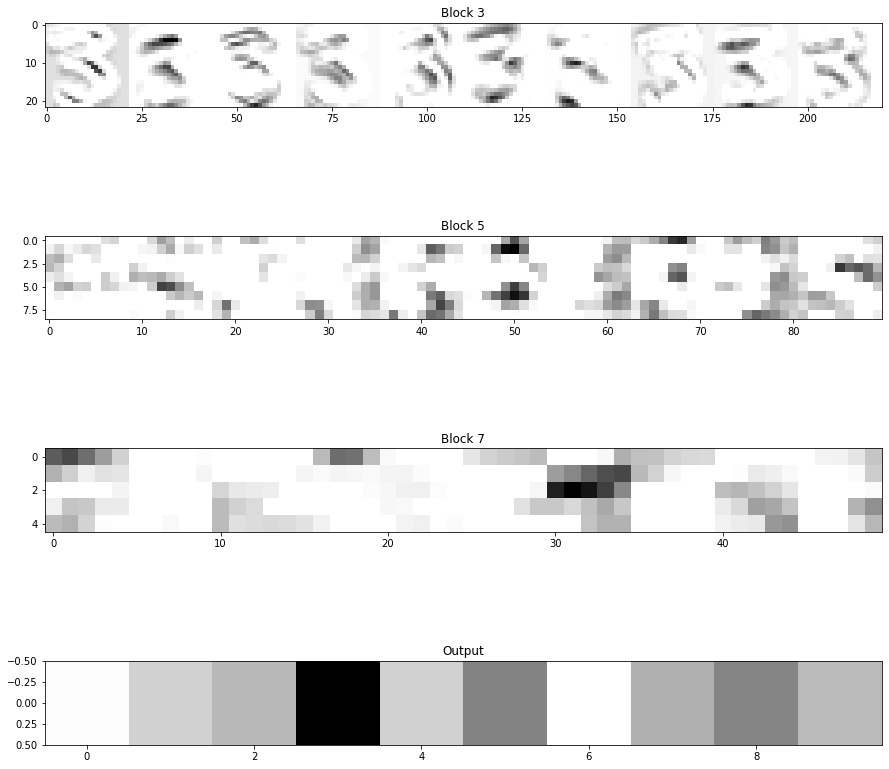

In [69]:
layer_activations = list(activations.items())
rows = len(layer_activations)
fig, ax = plt.subplots(rows, 1, figsize=(15, 15))
plt.set_cmap('gray_r')

for i in range(rows):
    layer, activation = layer_activations[i]
    ax[i].set_title(layer)
    ax[i].imshow(activation)

plt.show()

## Loss and accuracy

In [0]:
train_dir_suffix = f'/content/drive/My Drive/log_mnist_s5/run_train_{experiment_name}'
test_dir_suffix = f'/content/drive/My Drive/log_mnist_s5/run_test_{experiment_name}'

train_1 = glob.glob(f'{train_dir_suffix}_*/events.out.tfevents.*')[-1]
test_1 = glob.glob(f'{test_dir_suffix}_*/events.out.tfevents.*')[-1]

In [71]:
experiment_data = {experiment_name: (train_1, test_1)}
summary = {}
for experiment, (train, test) in experiment_data.items():
  train_data = {}
  test_data = {}
  summary[experiment] = {}
  for e in tf.compat.v1.train.summary_iterator(train):
      for v in e.summary.value:
          if v.tag not in train_data:
              train_data[v.tag] = []
          train_data[v.tag].append(v.simple_value)
  for e in tf.compat.v1.train.summary_iterator(test):
        for v in e.summary.value:
            if v.tag not in test_data:
                test_data[v.tag] = []
            test_data[v.tag].append(v.simple_value)
  summary[experiment]['train'] = train_data
  summary[experiment]['test'] = test_data

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


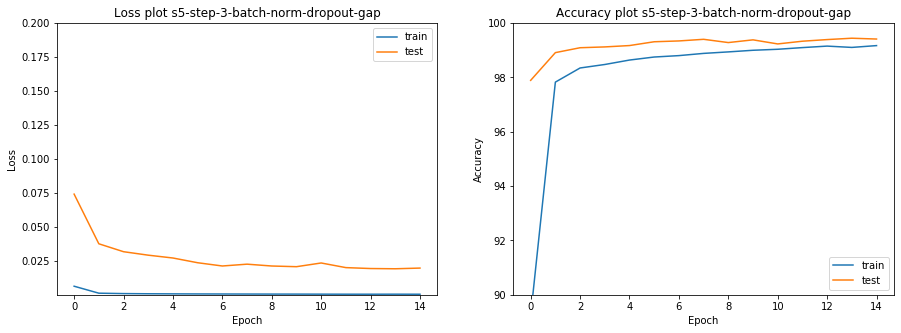

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(summary[experiment]['train']['loss'])
axs[0].plot(summary[experiment]['test']['loss'])
axs[0].set_title(f'Loss plot {experiment}')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylim([1e-5, 0.2])
axs[0].legend(['train', 'test'], loc='best')

axs[1].plot(summary[experiment]['train']['accuracy'])
axs[1].plot(summary[experiment]['test']['accuracy'])
axs[1].set_title(f'Accuracy plot {experiment}')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylim([90, 100])
axs[1].legend(['train', 'test'], loc='best')

plt.show()

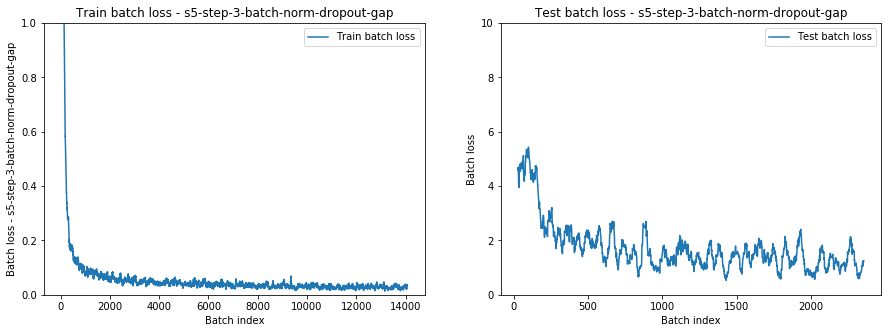

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

window_size = 30
  
smooth_train_batch_loss = pd.Series(summary[experiment]['train']['train/batch_loss']).rolling(window_size).mean()
smooth_test_batch_loss = pd.Series(summary[experiment]['test']['test/batch_loss']).rolling(window_size).mean()

axs[0].plot(smooth_train_batch_loss)
axs[0].legend([f'Train batch loss'], loc='best')
axs[0].set_title(f'Train batch loss - {experiment}')
axs[0].set_ylabel(f'Batch loss - {experiment}')
axs[0].set_xlabel('Batch index')
axs[0].set_ylim([0, 1])
axs[1].plot(smooth_test_batch_loss)
axs[1].legend([f'Test batch loss'], loc='best')
axs[1].set_title(f'Test batch loss - {experiment}')
axs[1].set_ylabel(f'Batch loss')
axs[1].set_xlabel('Batch index')
axs[1].set_ylim([0, 10])
  
plt.show()

# Target
 - Introduce GAP layer
 - Blow up number of parameters to compensate for GAP layer

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **99.10** |
| _Best test accuracy_| **99.44** |
| _Best epoch number_| **14** |
| _Parameter count_ | **9,608** |

# Analysis
 - Very good model
 - Meets the targets
 - Number of parameters reduced greatly with GAP alone (8K parameters reduced to 3K). Provided oppurtunity to increase the capacity of model(3K parameters increased to 9K)
 - Dropout very critical as slight modification of droput rate modifies accuracies too much 